In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from scipy.stats import pearsonr, spearmanr

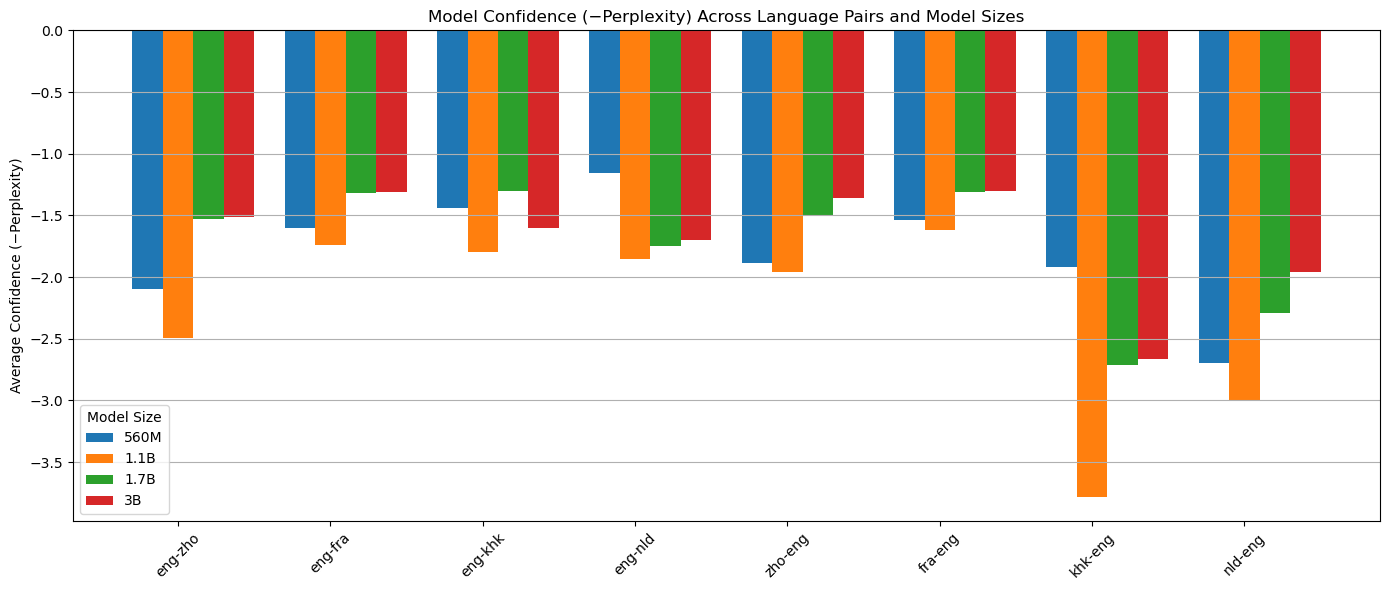

In [2]:
# Setup
model_sizes = ["560", "1b1", "1b7", "3b"]
size_labels = {"560": "560M", "1b1": "1.1B", "1b7": "1.7B", "3b": "3B"}
size_to_folder = {
    "560": "csv_results_560",
    "1b1": "csv_results_1b1",
    "1b7": "csv_results_1b7",
    "3b": "csv_results_3b"
}
lang_pairs = ["eng-zho", "eng-fra", "eng-khk", "eng-nld", "zho-eng", "fra-eng", "khk-eng", "nld-eng"]
metrics = ["bleu", "meteor", "comet_ref", "comet_wmt22"]

# Data
confidence_scores = {lp: [] for lp in lang_pairs}
base_path = r"C:\Users\gerri\Documents\jaar3\thesis\exp1"

for size in model_sizes:
    folder = size_to_folder[size]
    for lp in lang_pairs:
        src, tgt = lp.split("-")
        filename = f"{src}-{tgt}_bloomz-{size}_flores200_results.csv"
        file_path = os.path.join(base_path, folder, filename)
        try:
            df = pd.read_csv(file_path)
            sub = df[df["strategy"] == "greedy"]
            if sub.empty:
                confidence_scores[lp].append(None)
                continue
            avg_conf = (-sub["perplexity"]).mean()
            confidence_scores[lp].append(avg_conf)
        except FileNotFoundError:
            confidence_scores[lp].append(None)

# Plot
fig, ax = plt.subplots(figsize=(14, 6))
bar_width = 0.2
x = np.arange(len(lang_pairs))

for i, size in enumerate(model_sizes):
    y_vals = [confidence_scores[lp][i] if confidence_scores[lp][i] is not None else 0 for lp in lang_pairs]
    ax.bar(x + i * bar_width, y_vals, width=bar_width, label=size_labels[size])

ax.set_title("Model Confidence (−Perplexity) Across Language Pairs and Model Sizes")
ax.set_xticks(x + bar_width)
ax.set_xticklabels(lang_pairs, rotation=45)
ax.set_ylabel("Average Confidence (−Perplexity)")
ax.grid(True, axis='y')
ax.legend(title="Model Size")
plt.tight_layout()
plt.show()


In [4]:
# Setup
model_sizes = ["560", "1b1", "1b7", "3b"]
size_labels = {"560": "560M", "1b1": "1.1B", "1b7": "1.7B", "3b": "3B"}
size_to_folder = {
    "560": "csv_results_560",
    "1b1": "csv_results_1b1",
    "1b7": "csv_results_1b7",
    "3b": "csv_results_3b"
}
lang_pairs = ["eng-zho", "eng-fra", "eng-khk", "eng-nld", "zho-eng", "fra-eng", "khk-eng", "nld-eng"]
base_path = r"C:\Users\gerri\Documents\jaar3\thesis\exp1"
target_metric_1 = "comet_ref"  # Correlation will be computed with respect to comet_ref
target_metric_2 = "comet_wmt22"  # Alternative metric for correlation
target_metric_3 = "meteor"
target_metric_4 = "bleu"

# Data
results = {lp: [] for lp in lang_pairs}
results_alt = {lp: [] for lp in lang_pairs}
results_alt2 = {lp: [] for lp in lang_pairs}
results_alt3 = {lp: [] for lp in lang_pairs}

for size in model_sizes:
    folder = size_to_folder[size]
    for lp in lang_pairs:
        src, tgt = lp.split("-")
        filename = f"{src}-{tgt}_bloomz-{size}_flores200_results.csv"
        file_path = os.path.join(base_path, folder, filename)
        try:
            df = pd.read_csv(file_path)
            sub = df[df["strategy"] == "greedy"]
            if sub.empty:
                results[lp].append((None, None, None))
                continue
            conf = (-sub["perplexity"]).mean()
            if target_metric_1 in sub.columns:
                pearson = pearsonr(-sub["perplexity"], sub[target_metric_1])[0]
                spearman = spearmanr(-sub["perplexity"], sub[target_metric_1])[0]
            if target_metric_2 in sub.columns:
                pearson_alt = pearsonr(-sub["perplexity"], sub[target_metric_2])[0]
                spearman_alt = spearmanr(-sub["perplexity"], sub[target_metric_2])[0]
            if target_metric_3 in sub.columns and target_metric_4 in sub.columns:
                pearson_alt2 = pearsonr(-sub["perplexity"], sub[target_metric_3])[0]
                spearman_alt2 = spearmanr(-sub["perplexity"], sub[target_metric_3])[0]
            if target_metric_4 in sub.columns:
                pearson_alt3 = pearsonr(-sub["perplexity"], sub[target_metric_4])[0]
                spearman_alt3 = spearmanr(-sub["perplexity"], sub[target_metric_4])[0]
            else:
                pearson, spearman = None, None
            results[lp].append((conf, pearson, spearman))
            results_alt[lp].append((conf, pearson_alt, spearman_alt))
            results_alt2[lp].append((conf, pearson_alt2, spearman_alt2))
            results_alt3[lp].append((conf, pearson_alt3, spearman_alt3))
        except FileNotFoundError:
            results[lp].append((None, None, None))

# LateX
header = r"""\begin{tabular}{lrrrrrrrrrrrr}
\toprule
 & \multicolumn{3}{r}{560M} & \multicolumn{3}{r}{1.1B} & \multicolumn{3}{r}{1.7B} & \multicolumn{3}{r}{3B} \\
 & Confidence & Pearson & Spearman & Confidence & Pearson & Spearman & Confidence & Pearson & Spearman & Confidence & Pearson & Spearman \\
('Language Pair', '') &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
"""

rows = []
for lp in lang_pairs:
    row = [lp]
    for i in range(len(model_sizes)):
        conf, pearson, spearman = results[lp][i]
        row.append(f"{conf:.3f}" if conf is not None else "-")
        row.append(f"{pearson:.3f}" if pearson is not None else "-")
        row.append(f"{spearman:.3f}" if spearman is not None else "-")
    rows.append(" & ".join(row) + r" \\")

# Averages
avg_row = ["Average"]
for i in range(len(model_sizes)):
    confs, pears, spears = [], [], []
    for lp in lang_pairs:
        conf, p, s = results[lp][i]
        if conf is not None: confs.append(conf)
        if p is not None: pears.append(p)
        if s is not None: spears.append(s)
    avg_row.append(f"{np.mean(confs):.3f}" if confs else "-")
    avg_row.append(f"{np.mean(pears):.3f}" if pears else "-")
    avg_row.append(f"{np.mean(spears):.3f}" if spears else "-")
rows.append(" & ".join(avg_row) + r" \\")

footer = r"""\bottomrule
\end{tabular}
"""

latex_table = header + "\n".join(rows) + "\n" + footer
print(latex_table)


\begin{tabular}{lrrrrrrrrrrrr}
\toprule
 & \multicolumn{3}{r}{560M} & \multicolumn{3}{r}{1.1B} & \multicolumn{3}{r}{1.7B} & \multicolumn{3}{r}{3B} \\
 & Confidence & Pearson & Spearman & Confidence & Pearson & Spearman & Confidence & Pearson & Spearman & Confidence & Pearson & Spearman \\
('Language Pair', '') &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
eng-zho & -2.093 & 0.432 & 0.563 & -2.493 & 0.406 & 0.501 & -1.530 & 0.465 & 0.558 & -1.511 & 0.487 & 0.508 \\
eng-fra & -1.602 & 0.583 & 0.638 & -1.737 & 0.567 & 0.564 & -1.320 & 0.640 & 0.696 & -1.310 & 0.656 & 0.685 \\
eng-khk & -1.440 & 0.208 & 0.194 & -1.798 & -0.201 & -0.257 & -1.299 & 0.205 & 0.190 & -1.603 & 0.144 & 0.201 \\
eng-nld & -1.157 & 0.319 & 0.267 & -1.853 & 0.427 & 0.400 & -1.748 & 0.560 & 0.648 & -1.698 & 0.556 & 0.572 \\
zho-eng & -1.886 & 0.495 & 0.541 & -1.963 & 0.480 & 0.511 & -1.500 & 0.638 & 0.688 & -1.363 & -0.199 & -0.111 \\
fra-eng & -1.538 & 0.576 & 0.598 & -1.618 & 0.524 & 0.546 & -1.314 & 0.655 & 0.65

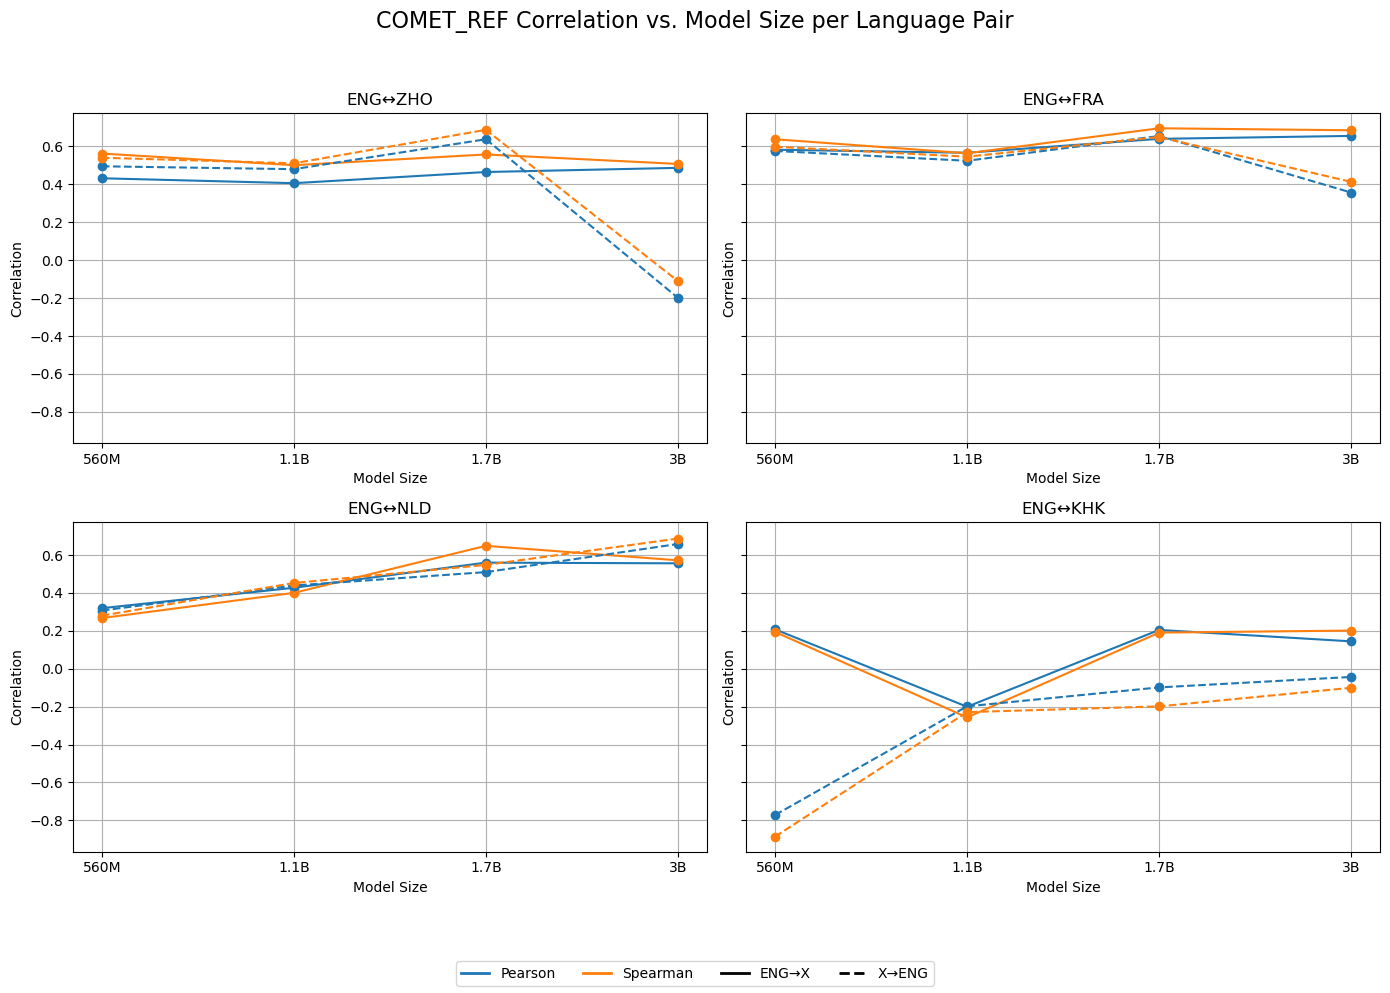

In [5]:
# Setup
model_sizes = ["560", "1b1", "1b7", "3b"]
size_labels = {"560": "560M", "1b1": "1.1B", "1b7": "1.7B", "3b": "3B"}
lang_pairs = ["eng-zho", "eng-fra", "eng-khk", "eng-nld", "zho-eng", "fra-eng", "khk-eng", "nld-eng"]
pair_groups = [("eng-zho", "zho-eng"), ("eng-fra", "fra-eng"), ("eng-nld", "nld-eng"), ("eng-khk", "khk-eng")]
correlation_types = ["pearson", "spearman"]
correlation_data_comet = {
    "pearson": {lp: [] for lp in lang_pairs},
    "spearman": {lp: [] for lp in lang_pairs}
}

for lp in lang_pairs:
    for i, size in enumerate(model_sizes):
        conf, pearson, spearman = results[lp][i]
        correlation_data_comet["pearson"][lp].append((size, pearson if pearson is not None else 0))
        correlation_data_comet["spearman"][lp].append((size, spearman if spearman is not None else 0))

corr_colors = {
    "pearson": "#1f77b4",
    "spearman": "#ff7f0e",
}
direction_styles = {
    "eng": "solid",
    "non-eng": "dashed",
}

# Plot
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10), sharey=True)
fig.suptitle("COMET_REF Correlation vs. Model Size per Language Pair", fontsize=16)

for ax, (pair1, pair2) in zip(axes.flat, pair_groups):
    for pair in [pair1, pair2]:
        direction = "eng" if pair.startswith("eng-") else "non-eng"
        for corr_type in correlation_types:
            points = correlation_data_comet[corr_type][pair]
            if points:
                sizes, scores = zip(*points)
                ax.plot(
                    [size_labels[s] for s in sizes], scores,
                    color=corr_colors[corr_type],
                    linestyle=direction_styles[direction],
                    marker='o',
                    label=f"{pair} ({corr_type})"
                )

    lang_code = pair1.split("-")[1].upper()
    ax.set_title(f"ENG↔{lang_code}")
    ax.set_xlabel("Model Size")
    ax.set_ylabel("Correlation")
    ax.grid(True)

# Legend
legend_lines = [
    plt.Line2D([0], [0], color=corr_colors["pearson"], lw=2, label="Pearson"),
    plt.Line2D([0], [0], color=corr_colors["spearman"], lw=2, label="Spearman"),
    plt.Line2D([0], [0], color="black", lw=2, linestyle="solid", label="ENG→X"),
    plt.Line2D([0], [0], color="black", lw=2, linestyle="dashed", label="X→ENG"),
]
fig.legend(handles=legend_lines, loc="lower center", ncol=4)
plt.tight_layout(rect=[0, 0.08, 1, 0.95])
plt.show()



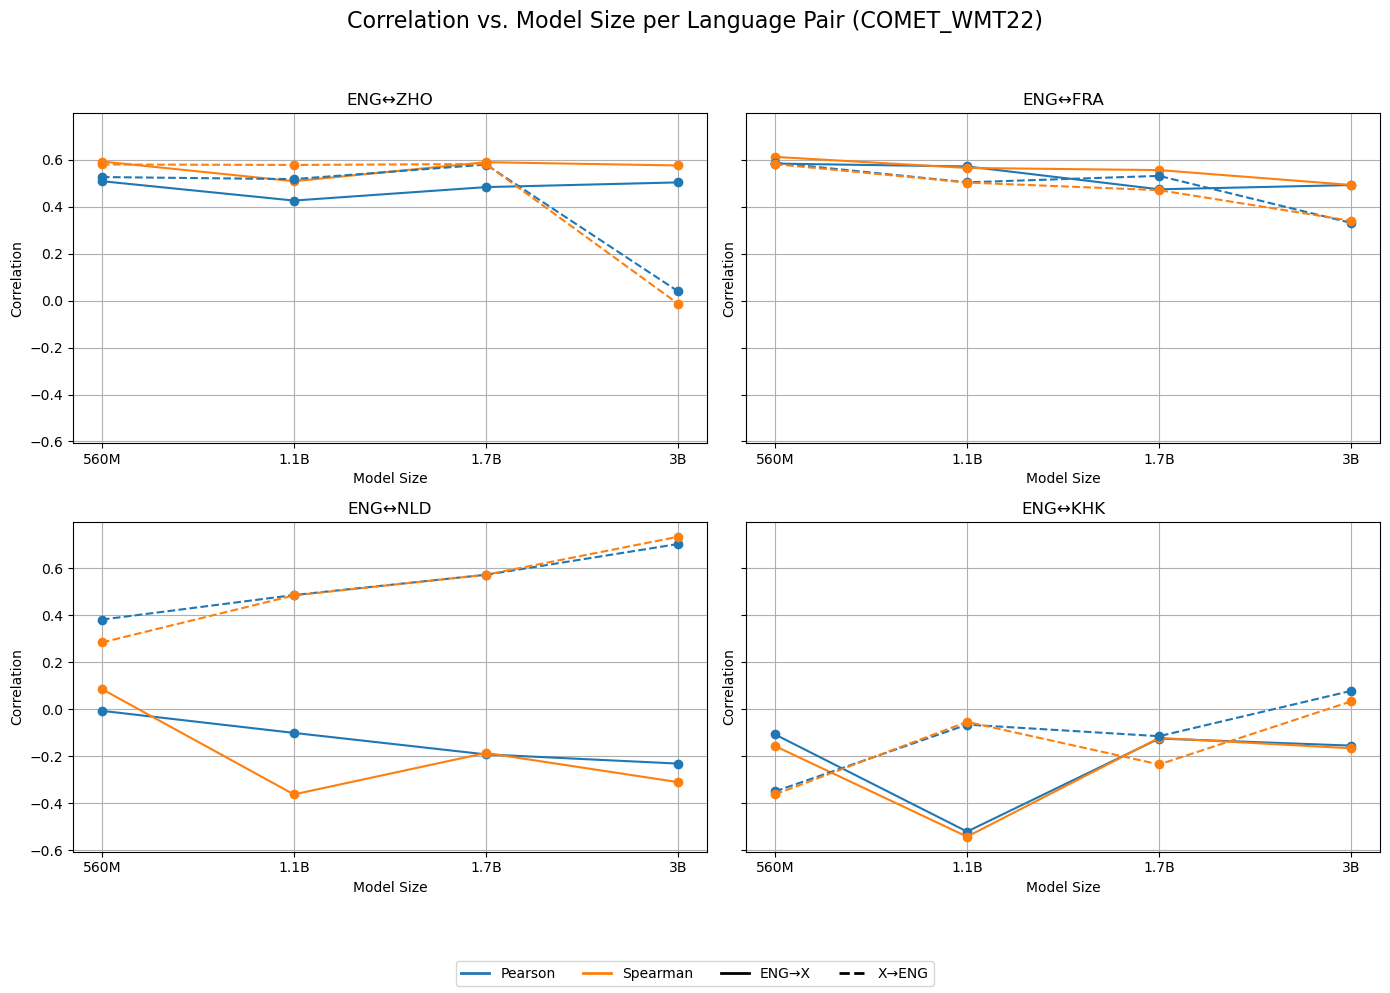

In [6]:
# Setup
model_sizes = ["560", "1b1", "1b7", "3b"]
size_labels = {"560": "560M", "1b1": "1.1B", "1b7": "1.7B", "3b": "3B"}
lang_pairs = ["eng-zho", "eng-fra", "eng-khk", "eng-nld", "zho-eng", "fra-eng", "khk-eng", "nld-eng"]
pair_groups = [("eng-zho", "zho-eng"), ("eng-fra", "fra-eng"), ("eng-nld", "nld-eng"), ("eng-khk", "khk-eng")]
correlation_types = ["pearson", "spearman"]

# Use alternate results (comet_wmt22)
correlation_data_alt = {
    "pearson": {lp: [] for lp in lang_pairs},
    "spearman": {lp: [] for lp in lang_pairs}
}

for lp in lang_pairs:
    for i, size in enumerate(model_sizes):
        conf, pearson, spearman = results_alt[lp][i]
        correlation_data_alt["pearson"][lp].append((size, pearson if pearson is not None else 0))
        correlation_data_alt["spearman"][lp].append((size, spearman if spearman is not None else 0))

corr_colors = {
    "pearson": "#1f77b4",
    "spearman": "#ff7f0e",
}
direction_styles = {
    "eng": "solid",
    "non-eng": "dashed",
}

# Plot
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10), sharey=True)
fig.suptitle("Correlation vs. Model Size per Language Pair (COMET_WMT22)", fontsize=16)

for ax, (pair1, pair2) in zip(axes.flat, pair_groups):
    for pair in [pair1, pair2]:
        direction = "eng" if pair.startswith("eng-") else "non-eng"
        for corr_type in correlation_types:
            points = correlation_data_alt[corr_type][pair]
            if points:
                sizes, scores = zip(*points)
                ax.plot(
                    [size_labels[s] for s in sizes], scores,
                    color=corr_colors[corr_type],
                    linestyle=direction_styles[direction],
                    marker='o',
                    label=f"{pair} ({corr_type})"
                )

    lang_code = pair1.split("-")[1].upper()
    ax.set_title(f"ENG↔{lang_code}")
    ax.set_xlabel("Model Size")
    ax.set_ylabel("Correlation")
    ax.grid(True)

# Legend
legend_lines = [
    plt.Line2D([0], [0], color=corr_colors["pearson"], lw=2, label="Pearson"),
    plt.Line2D([0], [0], color=corr_colors["spearman"], lw=2, label="Spearman"),
    plt.Line2D([0], [0], color="black", lw=2, linestyle="solid", label="ENG→X"),
    plt.Line2D([0], [0], color="black", lw=2, linestyle="dashed", label="X→ENG"),
]
fig.legend(handles=legend_lines, loc="lower center", ncol=4)
plt.tight_layout(rect=[0, 0.08, 1, 0.95])
plt.show()


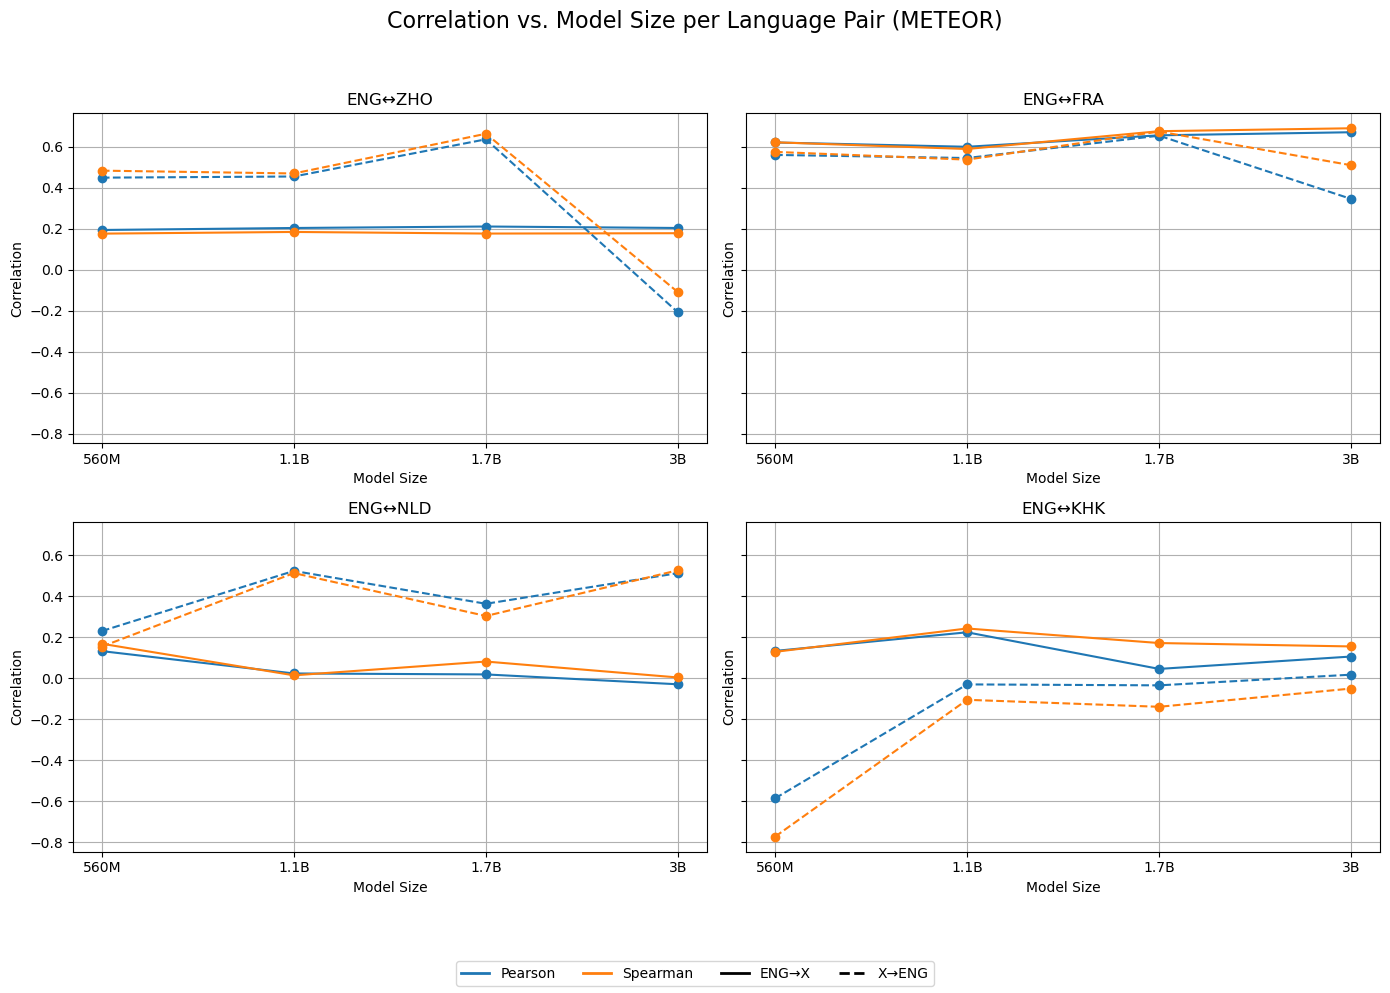

In [7]:
# Setup
model_sizes = ["560", "1b1", "1b7", "3b"]
size_labels = {"560": "560M", "1b1": "1.1B", "1b7": "1.7B", "3b": "3B"}
lang_pairs = ["eng-zho", "eng-fra", "eng-khk", "eng-nld", "zho-eng", "fra-eng", "khk-eng", "nld-eng"]
pair_groups = [("eng-zho", "zho-eng"), ("eng-fra", "fra-eng"), ("eng-nld", "nld-eng"), ("eng-khk", "khk-eng")]
correlation_types = ["pearson", "spearman"]

# Alternate results  (meteor)
correlation_data_alt = {
    "pearson": {lp: [] for lp in lang_pairs},
    "spearman": {lp: [] for lp in lang_pairs}
}

for lp in lang_pairs:
    for i, size in enumerate(model_sizes):
        conf, pearson, spearman = results_alt2[lp][i]
        correlation_data_alt["pearson"][lp].append((size, pearson if pearson is not None else 0))
        correlation_data_alt["spearman"][lp].append((size, spearman if spearman is not None else 0))

corr_colors = {
    "pearson": "#1f77b4",
    "spearman": "#ff7f0e",
}
direction_styles = {
    "eng": "solid",
    "non-eng": "dashed",
}

# Plot
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10), sharey=True)
fig.suptitle("Correlation vs. Model Size per Language Pair (METEOR)", fontsize=16)

for ax, (pair1, pair2) in zip(axes.flat, pair_groups):
    for pair in [pair1, pair2]:
        direction = "eng" if pair.startswith("eng-") else "non-eng"
        for corr_type in correlation_types:
            points = correlation_data_alt[corr_type][pair]
            if points:
                sizes, scores = zip(*points)
                ax.plot(
                    [size_labels[s] for s in sizes], scores,
                    color=corr_colors[corr_type],
                    linestyle=direction_styles[direction],
                    marker='o',
                    label=f"{pair} ({corr_type})"
                )

    lang_code = pair1.split("-")[1].upper()
    ax.set_title(f"ENG↔{lang_code}")
    ax.set_xlabel("Model Size")
    ax.set_ylabel("Correlation")
    ax.grid(True)

# Legend
legend_lines = [
    plt.Line2D([0], [0], color=corr_colors["pearson"], lw=2, label="Pearson"),
    plt.Line2D([0], [0], color=corr_colors["spearman"], lw=2, label="Spearman"),
    plt.Line2D([0], [0], color="black", lw=2, linestyle="solid", label="ENG→X"),
    plt.Line2D([0], [0], color="black", lw=2, linestyle="dashed", label="X→ENG"),
]
fig.legend(handles=legend_lines, loc="lower center", ncol=4)
plt.tight_layout(rect=[0, 0.08, 1, 0.95])
plt.show()


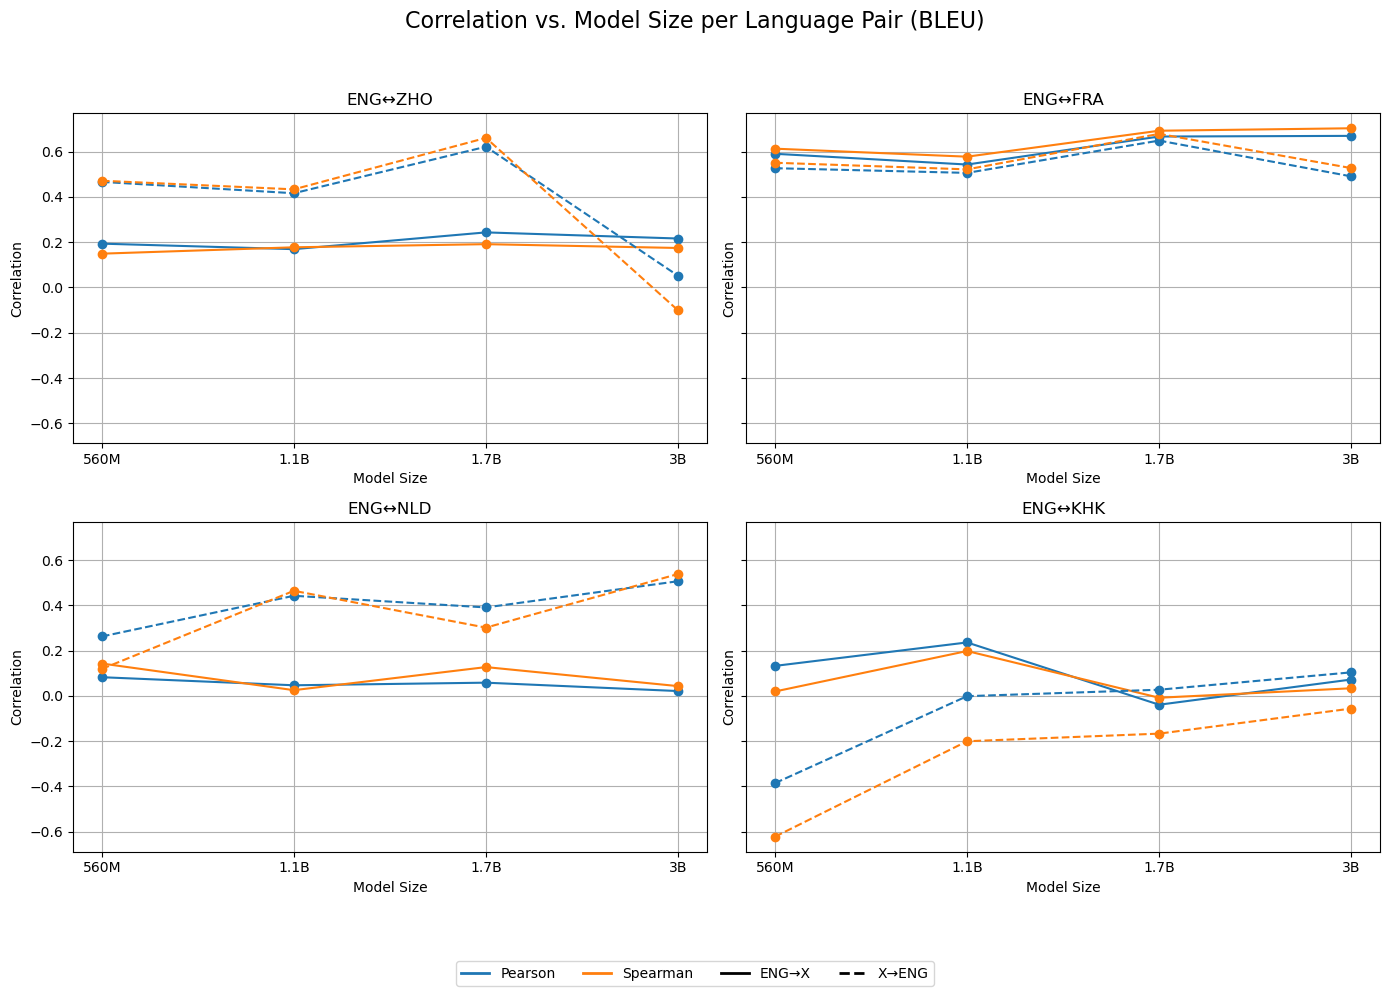

In [8]:
# Setup
model_sizes = ["560", "1b1", "1b7", "3b"]
size_labels = {"560": "560M", "1b1": "1.1B", "1b7": "1.7B", "3b": "3B"}
lang_pairs = ["eng-zho", "eng-fra", "eng-khk", "eng-nld", "zho-eng", "fra-eng", "khk-eng", "nld-eng"]
pair_groups = [("eng-zho", "zho-eng"), ("eng-fra", "fra-eng"), ("eng-nld", "nld-eng"), ("eng-khk", "khk-eng")]
correlation_types = ["pearson", "spearman"]

# Use alternate results (bleu)
correlation_data_alt = {
    "pearson": {lp: [] for lp in lang_pairs},
    "spearman": {lp: [] for lp in lang_pairs}
}

for lp in lang_pairs:
    for i, size in enumerate(model_sizes):
        conf, pearson, spearman = results_alt3[lp][i]
        correlation_data_alt["pearson"][lp].append((size, pearson if pearson is not None else 0))
        correlation_data_alt["spearman"][lp].append((size, spearman if spearman is not None else 0))

corr_colors = {
    "pearson": "#1f77b4",
    "spearman": "#ff7f0e",
}
direction_styles = {
    "eng": "solid",
    "non-eng": "dashed",
}

# Plot
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10), sharey=True)
fig.suptitle("Correlation vs. Model Size per Language Pair (BLEU)", fontsize=16)

for ax, (pair1, pair2) in zip(axes.flat, pair_groups):
    for pair in [pair1, pair2]:
        direction = "eng" if pair.startswith("eng-") else "non-eng"
        for corr_type in correlation_types:
            points = correlation_data_alt[corr_type][pair]
            if points:
                sizes, scores = zip(*points)
                ax.plot(
                    [size_labels[s] for s in sizes], scores,
                    color=corr_colors[corr_type],
                    linestyle=direction_styles[direction],
                    marker='o',
                    label=f"{pair} ({corr_type})"
                )

    lang_code = pair1.split("-")[1].upper()
    ax.set_title(f"ENG↔{lang_code}")
    ax.set_xlabel("Model Size")
    ax.set_ylabel("Correlation")
    ax.grid(True)

# Legend
legend_lines = [
    plt.Line2D([0], [0], color=corr_colors["pearson"], lw=2, label="Pearson"),
    plt.Line2D([0], [0], color=corr_colors["spearman"], lw=2, label="Spearman"),
    plt.Line2D([0], [0], color="black", lw=2, linestyle="solid", label="ENG→X"),
    plt.Line2D([0], [0], color="black", lw=2, linestyle="dashed", label="X→ENG"),
]
fig.legend(handles=legend_lines, loc="lower center", ncol=4)
plt.tight_layout(rect=[0, 0.08, 1, 0.95])
plt.show()
